In [1]:
# -- Bib
import os
import sys
sys.path.append("../..")

import glob
from pathlib import Path
import networkx as nx
import geopandas as gpd
import pandas as pd
import datetime as dt
import geopandas as gpd
import numpy as np
from shapely.geometry import MultiPolygon, Polygon
from dateutil.relativedelta import relativedelta
import mapclassify
from collections import defaultdict
from scipy.stats import linregress
from fluxsus.preprocessing.processnet import NetProperties

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle

idx = pd.IndexSlice

# -- base paths
basepath = Path.home().joinpath("Documents", "data")
cnespath = basepath.joinpath("opendatasus", "cnes")
geopath = basepath.joinpath("shapefilesceqgis")
simpath = basepath.joinpath("sim", "DBF")
gmlpath = basepath.joinpath("redes_aih")
ccapath = basepath.joinpath("cca_erneson")
figpath = gmlpath.joinpath("doc_final")

# -- load geo
geodata_df = gpd.read_parquet(geopath.joinpath("ce_geodata.parquet"))
ce_geodata_df = gpd.read_parquet(geopath.joinpath("ce_regiao_saude_municipios.parquet"))

pop_2022_ibge = pd.read_parquet(geopath.joinpath("pop_ce_2022_ibge.parquet"))
geodata_df = geodata_df.merge(pop_2022_ibge)

name_macro = {
    1: "Grande Fortaleza\nBaturité", 2: "Litoral Oeste\nVale do Curu\nLitoral Norte",
    3: "Cariri", 4: "Centro Sul", 5: "Sertão Central", 6: "Litoral Leste\nJaguaribe",
    7: "Sertão dos Inhamuns\nCrateús", 8: "Serra da Ibiapaba\nSertão de Sobral"
}

macro_df = geodata_df.drop_duplicates("MACRO_ID")[["MACRO_ID", "MACRO_NOME"]]
ce_geodata_df = ce_geodata_df.merge(macro_df, how="left")

## process

In [26]:
trials = 20
suffix = 'agg_1801_2306'
fname = f'cityfluxnet_{suffix}.gml'
graph = nx.read_gml(os.path.join(gmlpath, 'novo_completo', fname))

# -- include 2022 population to nodes
pop_2022 = dict(zip(geodata_df['GEOCOD6'], geodata_df['2022']))

for v in graph.nodes():
    muncode = graph.nodes[v]['municipio_code']
    graph.nodes[v]['pop_2022'] = pop_2022[muncode]

# -- normalize flow based on the population
factor = 1000
for src, tgt in graph.edges():
    pop_src = graph.nodes[src]['pop_2022']
    outflow = graph.edges[src, tgt]['admission_count']
    outflow_cost = graph.edges[src, tgt]['total_cost']
    graph.edges[src, tgt]['admission_count_norm_pop'] = (outflow/pop_src)*factor
    graph.edges[src, tgt]['total_cost_norm_pop'] = (outflow_cost/pop_src)

# -- calculate in and out flow for each node
graph_prop = NetProperties(graph)
graph_prop.calculate_in_flow(weight_people_col='admission_count', weight_cost_col='total_cost').calculate_out_flow(weight_people_col='admission_count', weight_cost_col='total_cost')
#graph_prop.process_infomap_graph(trials=trials, weight_people_col='admission_count_norm_pop', weight_cost_col='total_cost_norm_pop', people_property_name='infomap_count_norm_pop_mod_id', cost_property_name='infomap_cost_norm_pop_mod_id')
graph_prop.process_infomap_graph(trials=trials, weight_people_col='admission_count', weight_cost_col='total_cost', people_property_name='infomap_count_norm_pop_mod_id', cost_property_name='infomap_cost_norm_pop_mod_id')

# -- create dict for infomap modules
infomap_code_to_mod_count = dict()
infomap_code_to_mod_cost = dict()
for v in graph.nodes():
    muncode = graph.nodes[v]['municipio_code']
    module_id1 = graph.nodes[v]['infomap_count_norm_pop_mod_id']
    module_id2 = graph.nodes[v]['infomap_cost_norm_pop_mod_id']
    infomap_code_to_mod_count.update({muncode:module_id1})
    infomap_code_to_mod_cost.update({muncode:module_id2})

geodata_df_mod = ce_geodata_df.copy()
geodata_df_mod["infomap_modules_count_norm_pop"] = geodata_df_mod["GEOCOD6"].map(infomap_code_to_mod_count)
geodata_df_mod["infomap_modules_cost_norm_pop"] = geodata_df_mod["GEOCOD6"].map(infomap_code_to_mod_cost)

cols = ["GEOCOD6", "infomap_modules_count_norm_pop", "infomap_modules_cost_norm_pop"]
#geodata_df_mod[cols].to_parquet(os.path.join(gmlpath, "dados_for_plot", f"geocod_to_infomap_modules_{suffix}_trials_{trials}.parquet"))

found 9 modules with codelength: 2.4949887995388256
found 4 modules with codelength: 2.478325999904898


In [27]:
fortaleza_module = geodata_df_mod[geodata_df_mod["NM_MUN"]=="FORTALEZA"]["infomap_modules_count_norm_pop"].iat[0]
crato_module = geodata_df_mod[geodata_df_mod["NM_MUN"]=="CRATO"]["infomap_modules_count_norm_pop"].iat[0]

geodata_df_mod['infomap_modules_count_norm_pop'] = geodata_df_mod[['NM_MUN', "infomap_modules_count_norm_pop"]].apply(lambda x: x['infomap_modules_count_norm_pop'] if x["NM_MUN"]!='IBICUITINGA' else fortaleza_module, axis=1)
geodata_df_mod['infomap_modules_count_norm_pop'] = geodata_df_mod[['NM_MUN', "infomap_modules_count_norm_pop"]].apply(lambda x: x['infomap_modules_count_norm_pop'] if x["NM_MUN"]!='ABAIARA' else crato_module, axis=1)

In [28]:
# -- specify base colors
# ---- original colors based on specific cities
# ---- new modules will be colored with the original colors if one of the cities below is included
cmap_macro_original = {1: "#ef476f", 2: "#ffb300", 3: "#04ae81", 4: "#118ab2", 5: "#073b4c"}

citycode_colors = {"230440": "#ef476f", "230730": "#073b4c", "230410": "#118ab2", "231140": "#ffb300", "231180": "#04ae81"}
citylabel_colors = {"58": "#ef476f", "98": "#073b4c", "49": "#118ab2", "150": "#ffb300", "154": "#04ae81"}
extra_colors = ["#00756a", "#bcb20f", "#ff8239", "#c6881c", "#00a2a3", "#4d4d4d"]

# -- create new cmap for new modules
cmap_infomap_count, cmap_infomap_hospbed, cmap_infomap_cost = {}, {}, {}
cmap_louvain_count, cmap_louvain_cost = {}, {}

def get_cmap(graph, citycode_colors, extra_colors, property_name):
    cmap = {}
    for v in graph.nodes():
        if graph.nodes[v]['municipio_code'] in citycode_colors.keys():
            if graph.nodes[v][property_name] not in cmap.keys():
                cmap.update({graph.nodes[v][property_name] : citycode_colors[graph.nodes[v]['municipio_code']]})
    extra_colors_ = extra_colors[:] + [ x for x in citycode_colors.values() if x not in cmap.values() ]
    dummy_index = 0
    for n in range(10):
        if n+1 not in cmap.keys():
            cmap.update({ n+1: extra_colors_[dummy_index]})
            dummy_index+=1
    return cmap

cmap_11 = get_cmap(graph, citycode_colors, extra_colors, 'infomap_count_norm_pop_mod_id')

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_27624\2996868099.py:12: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geodata_df_mod.plot(column=f'infomap_modules_{mode}_norm_pop', color=geodata_df_mod["infomap_modules_count_norm_pop"].map(cmap_11), scheme="User_Defined",


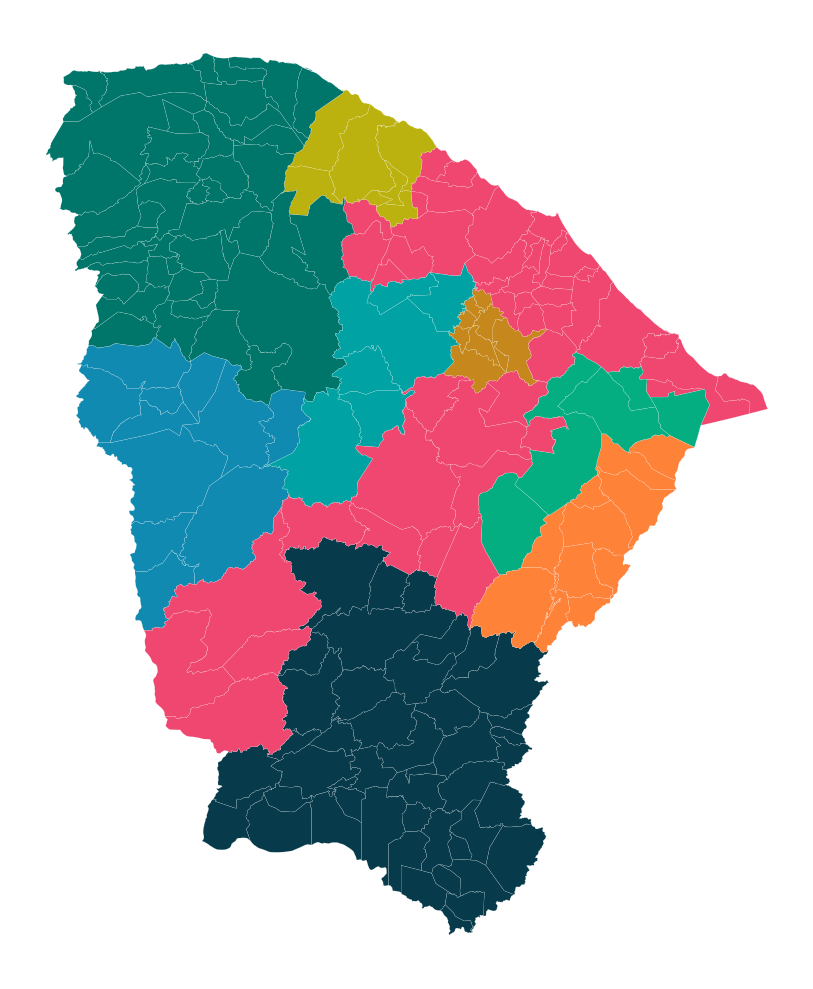

In [56]:
cmap_new_all = {1: "#ef476f", 2: "#073b4c", 3: "#ca35b4", 4: "#1e39ae", 5: "#118ab2", 6: "#33ccff", 7: "#7220f6", 8: "#ffb300", 9: "#04ae81"}

fig_mapa, ax_mapa = plt.subplots(1,1, figsize=(15.5,10))
mode = 'count'
modules = geodata_df_mod[f'infomap_modules_{mode}_norm_pop'].unique().tolist()
map_modules = dict(zip(modules, [ n for n in range(len(modules)) ]))
geodata_df_mod[f'infomap_modules_{mode}_norm_pop_seq_index'] = geodata_df_mod[f'infomap_modules_{mode}_norm_pop'].map(map_modules)

#geodata_df_mod.plot(column=f'infomap_modules_{mode}_norm_pop', cmap='Spectral', scheme="User_Defined", 
#         legend=False, classification_kwds=dict(bins=sorted(modules)), linewidth=0.1, edgecolor="#ffffff",
#         ax=ax_mapa)
geodata_df_mod.plot(column=f'infomap_modules_{mode}_norm_pop', color=geodata_df_mod["infomap_modules_count_norm_pop"].map(cmap_11), scheme="User_Defined", 
         legend=False, classification_kwds=dict(bins=sorted(modules)), linewidth=0.1, edgecolor="#ffffff",
         ax=ax_mapa)
#aux_geo.plot(ax=ax_mapa, color="none", edgecolor="#333333", linewidth=0.4, ls='-')
#ce_df.plot(ax=ax_mapa, color='none', edgecolor="#333333", linewidth=1.5)

ax_mapa.axis('off')
ax_mapa.tick_params(which='both', length=0, labelsize=0)

fig_mapa.tight_layout()
fig_mapa.savefig(os.path.join(figpath, f"infomap_not_normed_1801_2306.png"), dpi=250, bbox_inches='tight')

**Infomap to the Infomap Fortaleza Cluster**

In [39]:
infomap_mod = fortaleza_module

suffix = 'agg_1801_2306'
fname = f'cityfluxnet_{suffix}.gml'
graph_fort = nx.read_gml(os.path.join(gmlpath, 'novo_completo', fname))

municip_to_consider = geodata_df_mod[geodata_df_mod['infomap_modules_count_norm_pop']==fortaleza_module]["GEOCOD6"].tolist()
print(municip_to_consider)

# -- filter graph_fort
nodes_to_remove = []
for v in graph_fort.nodes():
    cur_municip = graph_fort.nodes[v]['municipio_code']
    if cur_municip not in municip_to_consider:
        nodes_to_remove.append(v)
graph_fort.remove_nodes_from(nodes_to_remove)
print(graph_fort.number_of_nodes())

# -- include 2022 population to nodes
pop_2022 = dict(zip(geodata_df['GEOCOD6'], geodata_df['2022']))

for v in graph_fort.nodes():
    muncode = graph_fort.nodes[v]['municipio_code']
    graph_fort.nodes[v]['pop_2022'] = pop_2022[muncode]

# -- normalize flow based on the population
factor = 1000
for src, tgt in graph_fort.edges():
    pop_src = graph_fort.nodes[src]['pop_2022']
    outflow = graph_fort.edges[src, tgt]['admission_count']
    outflow_cost = graph_fort.edges[src, tgt]['total_cost']
    graph_fort.edges[src, tgt]['admission_count_norm_pop'] = (outflow/pop_src)*factor
    graph_fort.edges[src, tgt]['total_cost_norm_pop'] = (outflow_cost/pop_src)

# -- calculate in and out flow for each node
graph_prop = NetProperties(graph_fort)
graph_prop.calculate_in_flow(weight_people_col='admission_count', weight_cost_col='total_cost').calculate_out_flow(weight_people_col='admission_count', weight_cost_col='total_cost')
#graph_prop.process_infomap_graph(trials=50, weight_people_col='admission_count_norm_pop', weight_cost_col='total_cost_norm_pop', people_property_name='infomap_count_norm_pop_mod_id', cost_property_name='infomap_cost_norm_pop_mod_id')
graph_prop.process_infomap_graph(trials=50, weight_people_col='admission_count', weight_cost_col='total_cost', people_property_name='infomap_count_norm_pop_mod_id', cost_property_name='infomap_cost_norm_pop_mod_id')

# -- create dict for infomap modules
infomap_code_to_mod_count = dict()
infomap_code_to_mod_cost = dict()
for v in graph_fort.nodes():
    muncode = graph_fort.nodes[v]['municipio_code']
    module_id1 = graph_fort.nodes[v]['infomap_count_norm_pop_mod_id']
    module_id2 = graph_fort.nodes[v]['infomap_cost_norm_pop_mod_id']
    infomap_code_to_mod_count.update({muncode:module_id1})
    infomap_code_to_mod_cost.update({muncode:module_id2})

geodata_df_mod1 = geodata_df.copy()
geodata_df_mod1["infomap_modules_count_norm_pop"] = geodata_df_mod1["GEOCOD6"].map(infomap_code_to_mod_count)
geodata_df_mod1["infomap_modules_cost_norm_pop"] = geodata_df_mod1["GEOCOD6"].map(infomap_code_to_mod_count)
geodata_df_mod1 = geodata_df_mod1[pd.notna(geodata_df_mod1["infomap_modules_count_norm_pop"])]

cols = ["GEOCOD6", "infomap_modules_count_norm_pop", "infomap_modules_cost_norm_pop"]
#geodata_df_mod[cols].to_parquet(os.path.join(gmlpath, "dados_for_plot", f"geocod_to_infomap_modules_{suffix}_trials_{trials}_infomap_of_fortaleza.parquet"))

['230015', '230195', '230945', '231010', '231160', '230100', '230350', '230370', '230395', '230428', '230440', '230495', '230523', '230625', '230765', '230770', '230960', '230970', '231085', '231020', '231025', '231240', '231260', '230090', '230460', '230630', '231070', '231335', '230220', '230110', '230445', '230535', '230620', '230040', '230150', '231030', '231330', '230185', '230393', '230526', '230533', '230835', '231050', '231130', '231140', '231270', '231300']
47
found 37 modules with codelength: 2.070466054447348
found 36 modules with codelength: 2.0193690993734688


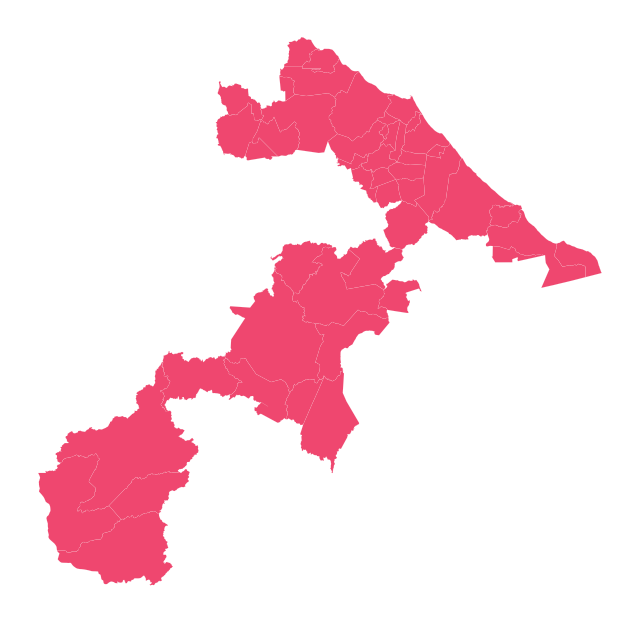

In [51]:
fig, ax = plt.subplots(1, figsize=(8,10))
geodata_df_mod1.plot(ax=ax, color=cmap_11[1], linewidth=0.05, edgecolor="#ffffff")
#aux_geo.plot(ax=ax, color='none', edgecolor="#1a1a1a", linewidth=0.2)
ax.axis('off')
fig.savefig(os.path.join(figpath, f"infomap_not_normed_big_fortaleza.png"), dpi=250, bbox_inches='tight')

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_27624\285860505.py:7: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geodata_df_mod1.plot(column=f'infomap_modules_{mode}_norm_pop', color=geodata_df_mod1["infomap_modules_count_norm_pop"].map(cmap_11), scheme="User_Defined",


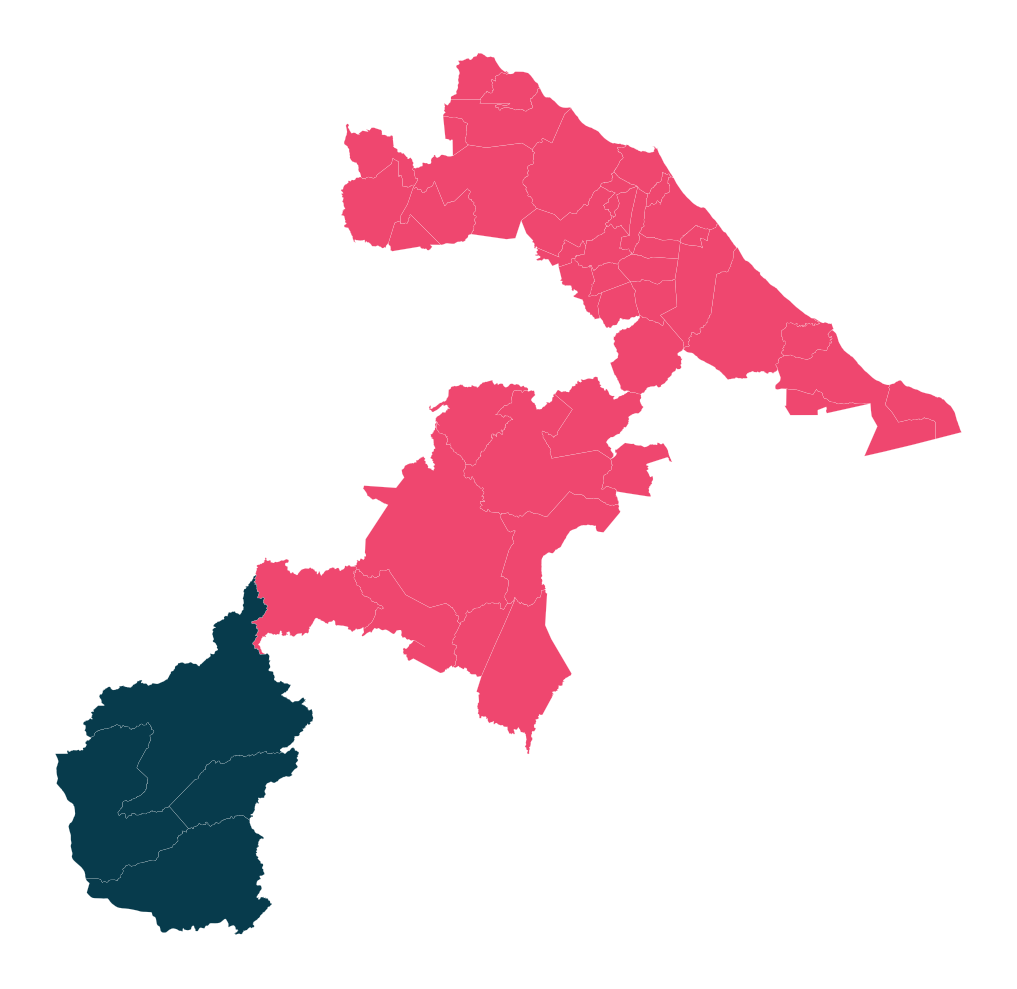

In [55]:
fig_mapa, ax_mapa = plt.subplots(1,1, figsize=(15.5,10))

mode = 'count'
modules = geodata_df_mod1[f'infomap_modules_{mode}_norm_pop'].unique().tolist()
#aux_geo.plot(ax=ax_mapa, color='none', edgecolor="#1a1a1a", linewidth=0.5)
#aux_geo_muni.plot(ax=ax_mapa, color='none', edgecolor="#1a1a1a", linewidth=0.5)
geodata_df_mod1.plot(column=f'infomap_modules_{mode}_norm_pop', color=geodata_df_mod1["infomap_modules_count_norm_pop"].map(cmap_11), scheme="User_Defined", 
         legend=False, classification_kwds=dict(bins=sorted(modules)), linewidth=0.1, edgecolor="#ffffff",
         ax=ax_mapa)

ax_mapa.axis('off')
ax_mapa.tick_params(which='both', length=0, labelsize=0)

fig_mapa.tight_layout()
#fig_mapa.suptitle(rf"{suffix}", fontsize=15)
fig_mapa.savefig(os.path.join(figpath, f"infomap_submodules_count_not_normalized_big_fortaleza.png"), dpi=250, bbox_inches='tight')

In [62]:
infomap_mod = 1

suffix = 'agg_1801_2306'
fname = f'cityfluxnet_{suffix}.gml'
graph_fort = nx.read_gml(os.path.join(gmlpath, 'novo_completo', fname))

municip_to_consider = geodata_df_mod1[geodata_df_mod1['infomap_modules_count_norm_pop']==1]["GEOCOD6"].tolist()
print(municip_to_consider)

# -- filter graph_fort
nodes_to_remove = []
for v in graph_fort.nodes():
    cur_municip = graph_fort.nodes[v]['municipio_code']
    if cur_municip not in municip_to_consider:
        nodes_to_remove.append(v)
graph_fort.remove_nodes_from(nodes_to_remove)
print(graph_fort.number_of_nodes())

# -- include 2022 population to nodes
pop_2022 = dict(zip(geodata_df['GEOCOD6'], geodata_df['2022']))

for v in graph_fort.nodes():
    muncode = graph_fort.nodes[v]['municipio_code']
    graph_fort.nodes[v]['pop_2022'] = pop_2022[muncode]

# -- normalize flow based on the population
factor = 1000
for src, tgt in graph_fort.edges():
    pop_src = graph_fort.nodes[src]['pop_2022']
    outflow = graph_fort.edges[src, tgt]['admission_count']
    outflow_cost = graph_fort.edges[src, tgt]['total_cost']
    graph_fort.edges[src, tgt]['admission_count_norm_pop'] = (outflow/pop_src)*factor
    graph_fort.edges[src, tgt]['total_cost_norm_pop'] = (outflow_cost/pop_src)

# -- calculate in and out flow for each node
graph_prop = NetProperties(graph_fort)
graph_prop.calculate_in_flow(weight_people_col='admission_count', weight_cost_col='total_cost').calculate_out_flow(weight_people_col='admission_count', weight_cost_col='total_cost')
#graph_prop.process_infomap_graph(trials=50, weight_people_col='admission_count_norm_pop', weight_cost_col='total_cost_norm_pop', people_property_name='infomap_count_norm_pop_mod_id', cost_property_name='infomap_cost_norm_pop_mod_id')
graph_prop.process_infomap_graph(trials=50, weight_people_col='admission_count_norm_pop', weight_cost_col='total_cost', people_property_name='infomap_count_norm_pop_mod_id', cost_property_name='infomap_cost_norm_pop_mod_id')

# -- create dict for infomap modules
infomap_code_to_mod_count = dict()
infomap_code_to_mod_cost = dict()
for v in graph_fort.nodes():
    muncode = graph_fort.nodes[v]['municipio_code']
    module_id1 = graph_fort.nodes[v]['infomap_count_norm_pop_mod_id']
    module_id2 = graph_fort.nodes[v]['infomap_cost_norm_pop_mod_id']
    infomap_code_to_mod_count.update({muncode:module_id1})
    infomap_code_to_mod_cost.update({muncode:module_id2})

geodata_df_mod2 = geodata_df.copy()
geodata_df_mod2["infomap_modules_count_norm_pop"] = geodata_df_mod2["GEOCOD6"].map(infomap_code_to_mod_count)
geodata_df_mod2["infomap_modules_cost_norm_pop"] = geodata_df_mod2["GEOCOD6"].map(infomap_code_to_mod_count)
geodata_df_mod2 = geodata_df_mod2[pd.notna(geodata_df_mod2["infomap_modules_count_norm_pop"])]

cols = ["GEOCOD6", "infomap_modules_count_norm_pop", "infomap_modules_cost_norm_pop"]
#geodata_df_mod[cols].to_parquet(os.path.join(gmlpath, "dados_for_plot", f"geocod_to_infomap_modules_{suffix}_trials_{trials}_infomap_of_fortaleza.parquet"))

['230015', '230090', '230100', '230110', '230185', '230195', '230220', '230350', '230370', '230393', '230395', '230428', '230440', '230445', '230460', '230495', '230523', '230526', '230533', '230535', '230620', '230625', '230630', '230765', '230770', '230835', '230945', '230960', '230970', '231010', '231020', '231025', '231050', '231070', '231085', '231130', '231140', '231160', '231240', '231260', '231270', '231300', '231335']
43
found 38 modules with codelength: 2.105323529211546
found 36 modules with codelength: 1.9804038278879688


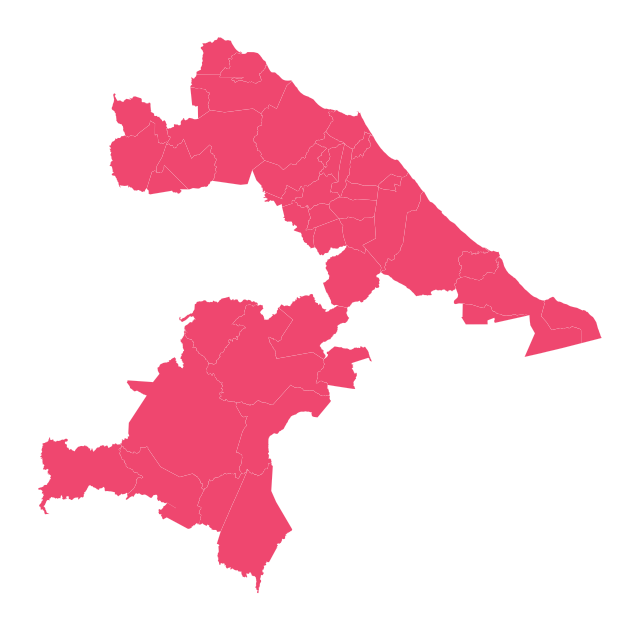

In [60]:
fig, ax = plt.subplots(1, figsize=(8,10))
geodata_df_mod2.plot(ax=ax, color=cmap_11[1], linewidth=0.05, edgecolor="#ffffff")
#aux_geo.plot(ax=ax, color='none', edgecolor="#1a1a1a", linewidth=0.2)
ax.axis('off')
fig.savefig(os.path.join(figpath, f"infomap_not_normed_big_fortaleza_subsub.png"), dpi=250, bbox_inches='tight')

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_27624\1844255129.py:7: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geodata_df_mod2.plot(column=f'infomap_modules_{mode}_norm_pop', color=geodata_df_mod2["infomap_modules_count_norm_pop"].map(cmap_11), scheme="User_Defined",


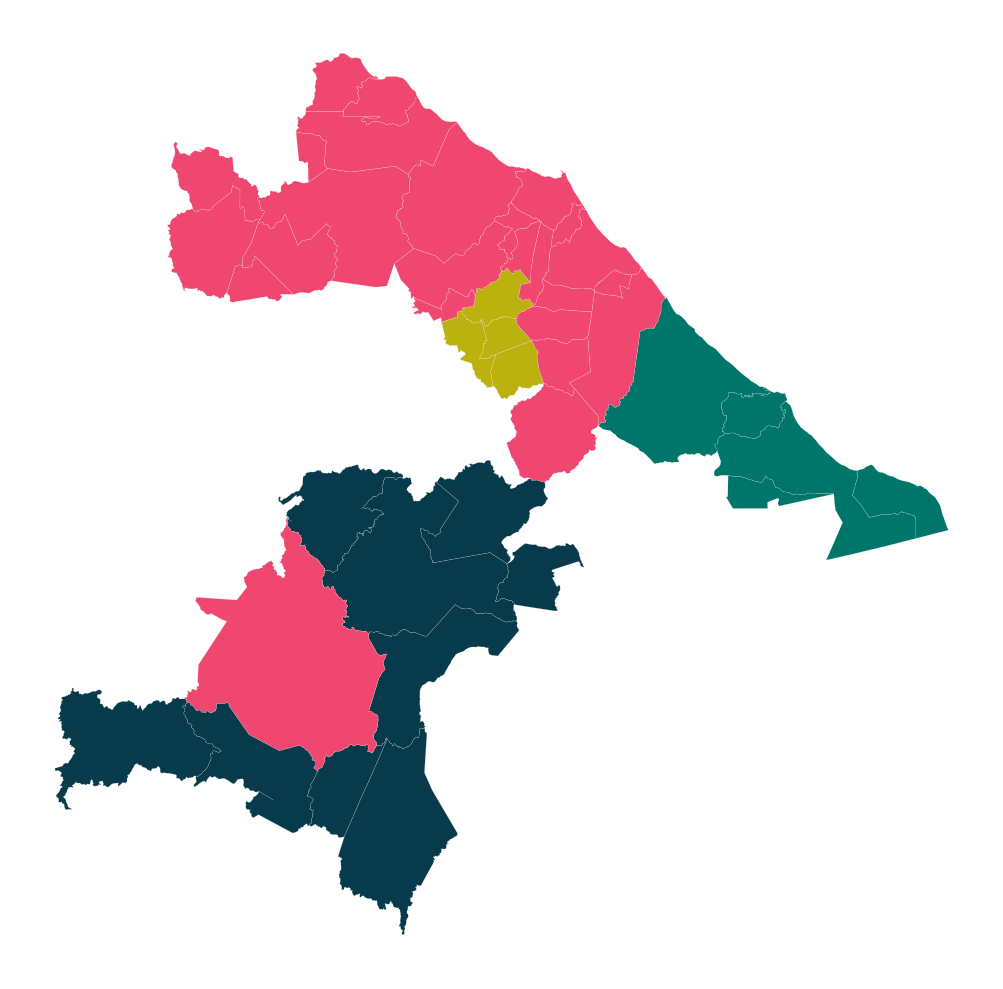

In [63]:
fig_mapa, ax_mapa = plt.subplots(1,1, figsize=(15.5,10))

mode = 'count'
modules = geodata_df_mod2[f'infomap_modules_{mode}_norm_pop'].unique().tolist()
#aux_geo.plot(ax=ax_mapa, color='none', edgecolor="#1a1a1a", linewidth=0.5)
#aux_geo_muni.plot(ax=ax_mapa, color='none', edgecolor="#1a1a1a", linewidth=0.5)
geodata_df_mod2.plot(column=f'infomap_modules_{mode}_norm_pop', color=geodata_df_mod2["infomap_modules_count_norm_pop"].map(cmap_11), scheme="User_Defined", 
         legend=False, classification_kwds=dict(bins=sorted(modules)), linewidth=0.1, edgecolor="#ffffff",
         ax=ax_mapa)

ax_mapa.axis('off')
ax_mapa.tick_params(which='both', length=0, labelsize=0)

fig_mapa.tight_layout()
#fig_mapa.suptitle(rf"{suffix}", fontsize=15)
fig_mapa.savefig(os.path.join(figpath, f"infomap_subsubmodules_count_not_normalized_big_fortaleza.png"), dpi=250, bbox_inches='tight')